# Transpiler estimation of IonQ

In [47]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info.operators import Operator
from qiskit.circuit import Parameter
from qiskit.circuit.library import GlobalPhaseGate
from math import pi
from qiskit import transpile

### Definición de $GPi(\phi)$

Para crear el circuito usamos que $\textcolor{Orange}{GPi(\phi) = -iR_z(2\phi)R_x(\pi)}$

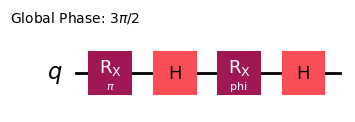

In [73]:
GPi_circuit = QuantumCircuit(1, name='GPi', global_phase=-pi/2)
phi = Parameter('phi')

GPi_circuit.rx(theta=pi, qubit=0)
GPi_circuit.h(0)
GPi_circuit.rx(theta=phi, qubit=0)
GPi_circuit.h(0)

GPi = GPi_circuit.to_gate()

GPi_circuit.draw("mpl")

### Definición de $GPi2(\phi)$

Para crear el circuito usamos que $\textcolor{Orange}{GPi2(\phi) = R_z(\phi)R_x(\pi/2)R_z(-\phi)}$

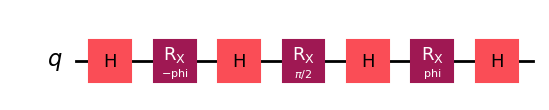

In [74]:
GPi2_circuit = QuantumCircuit(1, name="GPi2")


GPi2_circuit.h(0)
GPi2_circuit.rx(theta=-phi, qubit = 0)
GPi2_circuit.h(0)
GPi2_circuit.rx(theta=pi/2, qubit=0)
GPi2_circuit.h(0)
GPi2_circuit.rx(theta=phi, qubit=0)
GPi2_circuit.h(0)

GPi2 = GPi2_circuit.to_gate()

GPi2_circuit.draw("mpl")

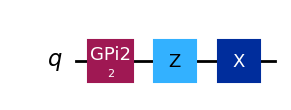

In [96]:
qc = QuantumCircuit(1)

qc.append(GPi2, [0])
qc.z(0)
qc.x(0)

bc = qc.assign_parameters({phi: 2})

bc.draw("mpl")

In [94]:
tqc = transpile(bc, basis_gates=['GPi', 'GPi2', 'rz'])

TranspilerError: 'Unable to translate the operations in the circuit: ["GPi", "x", "z"] to the backend\'s (or manually specified) target basis: {"switch_case", "if_else", "GPi2", "delay", "while_loop", "measure", "GPi", "rz", "store", "barrier", "for_loop", "reset", "snapshot"}. This likely means the target basis is not universal or there are additional equivalence rules needed in the EquivalenceLibrary being used. For more details on this error see: https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes. BasisTranslator#translation-errors'

2


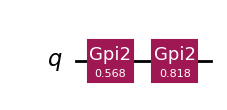

In [99]:
import qiskit.circuit.random
import qiskit_ionq
import numpy as np
from qiskit import QuantumCircuit, transpile
import matplotlib.pyplot as plt


def compile_to_ionq_native_gates(qc, check=False):
    qc_new = transpile(qc, basis_gates=["id", "rx", "ry", "rz", "cx"])
    qc_new = cnot_to_msgate(qc_new, check=check)
    qc_new = rx_ry_to_rz(qc_new, check=check)
    qc_new = rx_ry_trivial_phases_to_gpigates(qc_new, check=check)
    qc_new = consume_rz_gates(qc_new, check=check)
    return qc_new


def check_qc_compilation(qc1, qc2):
    qc1_unitary = qiskit.quantum_info.Operator(qc1).data
    qc2_unitary = qiskit.quantum_info.Operator(qc2).data
    identity = np.eye(*qc2_unitary.shape)
    prod = np.conj(qc2_unitary).T @ qc1_unitary
    global_phase = prod[0][0]
    prod *= np.conj(global_phase)
    assert np.allclose(prod, identity)


def cnot_to_msgate(qc, check=False):
    qc_new = QuantumCircuit(qc.qregs[0])
    for gate in qc.data:
        if gate.operation.name == "cx":
            control = gate.qubits[0]
            target = gate.qubits[1]
            qc_new.ry(np.pi / 2, control)
            qc_new.append(qiskit_ionq.MSGate(0, 0, 1 / 4), [control, target])
            qc_new.rx(-np.pi / 2, control)
            qc_new.rx(-np.pi / 2, target)
            qc_new.ry(-np.pi / 2, control)
        else:
            qc_new.append(gate)
    if check:
        check_qc_compilation(qc_new, qc)
    return qc_new


def rx_ry_to_rz(qc, check=False):
    qc_new = QuantumCircuit(qc.qregs[0])
    trivial_phases = np.array([0, 1 / 2, 1, 3 / 2]) * np.pi
    for gate in qc.data:
        if gate.operation.name == "rx":
            phase = gate.operation.params[0]
            if np.all(np.abs((trivial_phases - phase) % (2 * np.pi)) > 1e-7):
                qubit = gate.qubits[0]
                qc_new.ry(-np.pi / 2, qubit)
                qc_new.rz(phase, qubit)
                qc_new.ry(np.pi / 2, qubit)
            else:
                qc_new.append(gate)
        elif gate.operation.name == "ry":
            phase = gate.operation.params[0]
            if np.all(np.abs((trivial_phases - phase) % (2 * np.pi)) > 1e-7):
                qubit = gate.qubits[0]
                qc_new.rx(np.pi / 2, qubit)
                qc_new.rz(phase, qubit)
                qc_new.rx(-np.pi / 2, qubit)
            else:
                qc_new.append(gate)
        else:
            qc_new.append(gate)
    if check:
        check_qc_compilation(qc_new, qc)
    return qc_new


def rx_ry_trivial_phases_to_gpigates(qc, check=False):
    qc_new = QuantumCircuit(qc.qregs[0])
    for gate in qc.data:
        if gate.operation.name == "rx":
            phase = gate.operation.params[0] % (2 * np.pi)
            qubit = gate.qubits[0]
            if abs(phase) < 1e-7 or abs(phase - (2 * np.pi)) < 1e-7:
                pass
            elif abs(phase - np.pi / 2) < 1e-7:
                qc_new.append(qiskit_ionq.GPI2Gate(0), [qubit])
            elif abs(phase - np.pi) < 1e-7:
                qc_new.append(qiskit_ionq.GPIGate(0), [qubit])
            elif abs(phase - 3 / 2 * np.pi) < 1e-7:
                qc_new.append(qiskit_ionq.GPI2Gate(1 / 2), [qubit])
        elif gate.operation.name == "ry":
            phase = gate.operation.params[0] % (2 * np.pi)
            qubit = gate.qubits[0]
            if abs(phase) < 1e-7 or abs(phase - (2 * np.pi)) < 1e-7:
                pass
            elif abs(phase - np.pi / 2) < 1e-7:
                qc_new.append(qiskit_ionq.GPI2Gate(1 / 4), [qubit])
            elif abs(phase - np.pi) < 1e-7:
                qc_new.append(qiskit_ionq.GPIGate(1 / 4), [qubit])
            elif abs(phase - 3 / 2 * np.pi) < 1e-7:
                qc_new.append(qiskit_ionq.GPI2Gate(3 / 4), [qubit])
        else:
            qc_new.append(gate)
    if check:
        check_qc_compilation(qc_new, qc)
    return qc_new


def consume_rz_gates(qc, check=False):
    qubit_phases = [0] * len(qc.qubits)
    qc_new = QuantumCircuit(qc.qregs[0])
    for gate in qc.data:
        if gate.operation.name == "rz":
            index = gate.qubits[0]._index
            qubit_phases[index] += gate.operation.params[0]
        elif gate.operation.name == "gpi":
            index = gate.qubits[0]._index
            phase = (gate.operation.params[0] - qubit_phases[index] / (2 * np.pi)) % 1.0
            qc_new.append(qiskit_ionq.GPIGate(phase), [index])
        elif gate.operation.name == "gpi2":
            index = gate.qubits[0]._index
            phase = (gate.operation.params[0] - qubit_phases[index] / (2 * np.pi)) % 1.0
            qc_new.append(qiskit_ionq.GPI2Gate(phase), [index])
        elif gate.operation.name == "ms":
            indices = [gate.qubits[0]._index, gate.qubits[1]._index]
            assert gate.operation.params[0] == 0 and gate.operation.params[1] == 0
            assert gate.operation.params[2] == 1 / 4
            phase_0 = (-qubit_phases[indices[0]] / (2 * np.pi)) % 1.0
            phase_1 = (-qubit_phases[indices[1]] / (2 * np.pi)) % 1.0
            qc_new.append(qiskit_ionq.MSGate(phase_0, phase_1, 1 / 4), indices)
        else:
            raise ValueError
    if check:
        qc_check = qc_new.copy()
        for i, phase in enumerate(qubit_phases):
            qc_check.rz(phase, i)
        check_qc_compilation(qc_check, qc)
    return qc_new


qc_compiled = compile_to_ionq_native_gates(bc, check=True)
qc.draw(output="mpl")
print(qc_compiled.depth())
qc_compiled.draw(output="mpl")